In [1]:
# Copyright (c) 2021-2060 Curtis G. Northcutt
# This file is part of cleanlab/label-errors.
#
# label-errors is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# cleanlab/label-errors is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License

# This agreement applies to this version and all previous versions of
# cleanlab/label-errors.

"""
This tutorial provides reproducible code to find the label errors for datasets:
MNIST, CIFAR-10, CIFAR-100, ImageNet, Caltech-256, Amazon Reviews, IMDB,
20News, and AudioSet. These datasets comprise 9 of the 10 datasets on
https://labelerrors.com .

Label errors are found using the pyx (predicted probs), pred (predicted labels),
and test label files, provided in this repo: (cleanlab/label-errors)

The QuickDraw dataset is excluded because the pyx file is 33GB and might
cause trouble on some machines. To find label errors in the QuickDraw dataset,
you can download the pyx file here:
https://github.com/cleanlab/label-errors/releases/tag/quickdraw-pyx-v1

This tutorial reproduces how we find the label errors on https://labelerrors.com
(prior to human validation on mTurk).

To more closely match the label errors on labelerrors.com and in the paper,
set reproduce_labelerrors_dot_com = True
"""

import cleanlab
import numpy as np
import json
from util import ALL_CLASSES
# To view the text data from labelerrors.com, we need:
from urllib.request import urlopen
# To view the image data from labelerrors.com, we need:
from skimage import io
from matplotlib import pyplot as plt

# Remove axes since we're plotting images, not graphs
rc = {"axes.spines.left" : False,
      "axes.spines.right" : False,
      "axes.spines.bottom" : False,
      "axes.spines.top" : False,
      "xtick.bottom" : False,
      "xtick.labelbottom" : False,
      "ytick.labelleft" : False,
      "ytick.left" : False}
plt.rcParams.update(rc)

In [2]:
datasets = [
    ('mnist_test_set', 'image'),
    ('cifar10_test_set', 'image'),
    ('cifar100_test_set', 'image'),
    ('caltech256', 'image'),
    ('imagenet_val_set', 'image'),
    ('20news_test_set', 'text'),
    ('imdb_test_set', 'text'),
    ('amazon', 'text'),
    ('audioset_eval_set', 'audio'),
]

In [3]:
# Load the filename mappings for various datasets
root_dir = "../dataset_indexing"
with open(root_dir + "/audioset_eval_set_index_to_youtube_id.json", 'r') as rf:
    AUDIOSET_INDEX_TO_YOUTUBE = json.load(rf)
with open(root_dir + "/imdb_test_set_index_to_filename.json", 'r') as rf:
    IMDB_INDEX_TO_FILENAME = json.load(rf)
with open(root_dir + "/imagenet_val_set_index_to_filepath.json", 'r') as rf:
    IMAGENET_INDEX_TO_FILEPATH = json.load(rf)
with open(root_dir + "/caltech256_index_to_filename.json", "r") as rf:
    CALTECH256_INDEX_TO_FILENAME = json.load(rf)    

In [4]:
def get_label_error_indices_to_match_labelerrors_com():
    """This method will reproduce the label errors found on labelerrors.com and
    match (within a few percentage) the counts of label errors in Table 1 in the
    label errors paper: https://arxiv.org/abs/2103.14749
    
    While reproducibility is nice, some of these methods have been improved, and
    if you are not reproducing the results in the paper, we recommend using the
    latest version of `cleanlab.pruning.get_noise_indices()`

    Variations in method is due to the fact that this research was
    conducted over the span of years. All methods use variations of
    confident learning."""

    if dataset == 'imagenet_val_set':
        cj = cleanlab.latent_estimation.compute_confident_joint(
            s=labels, psx=pyx, calibrate=False, )
        num_errors = cj.sum() - cj.diagonal().sum()
    elif dataset == 'mnist_test_set':
        cj = cleanlab.latent_estimation.compute_confident_joint(
            s=labels, psx=pyx, calibrate=False, )
        label_errors_bool = cleanlab.pruning.get_noise_indices(
            s=labels, psx=pyx, confident_joint=cj, prune_method='prune_by_class',
        )
        num_errors = sum(label_errors_bool)
    elif dataset != 'audioset_eval_set':  # Audioset is special case: it is multi-label
        cj = cleanlab.latent_estimation.compute_confident_joint(
            s=labels, psx=pyx, calibrate=False, )
        num_errors = cleanlab.latent_estimation.num_label_errors(
            labels=labels, psx=pyx, confident_joint=cj, )
    
    if dataset == 'audioset_eval_set':  # Special case (multi-label) (TODO: update)
        label_error_indices = cleanlab.pruning.get_noise_indices(
            s=labels, psx=pyx, multi_label=True,
            sorted_index_method='self_confidence', )
        label_error_indices = label_error_indices[:307]
    else:
        prob_label = np.array([pyx[i, l] for i, l in enumerate(labels)])
        max_prob_not_label = np.array(
            [max(np.delete(pyx[i], l, -1)) for i, l in enumerate(labels)])
        normalized_margin = prob_label - max_prob_not_label
        label_error_indices = np.argsort(normalized_margin)[:num_errors]

    return label_error_indices

# Find label errors in each dataset

In [5]:
# By default, the code below will use the most up-to-date theory and algorithms
# of confident learning, implemented in the cleanlab package.
# We recommend this for best results.
# However, if you need to more closely match the label errors 
# to match https://labelerrors.com, set `reproduce_labelerrors_dot_com = True`.
# There may be discrepancies in counts due to improvements to cleanlab
# since the work was published.

# Set to False for best/most-recent results (this approach also runs faster)
# Set to True to match the label errors on https://labelerrors.com
reproduce_labelerrors_website = False  

Dataset: Mnist_test_set
Finding label errors using cleanlab for 10,000 examples and 10 classes...
Estimated number of errors in mnist_test_set: 15


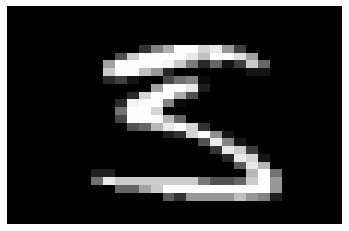

 * Mnist_test_set Given Label: 5
 * We Guess (argmax prediction): 3
 * Label Error Found: https://labelerrors.com/static/mnist/2597.png

Dataset: Cifar10_test_set
Finding label errors using cleanlab for 10,000 examples and 10 classes...
Estimated number of errors in cifar10_test_set: 284


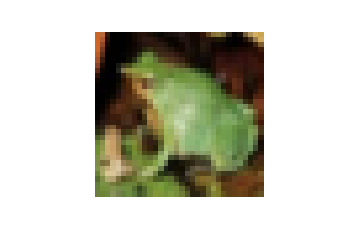

 * Cifar10_test_set Given Label: cat
 * We Guess (argmax prediction): frog
 * Label Error Found: https://labelerrors.com/static/cifar10/2405.png

Dataset: Cifar100_test_set
Finding label errors using cleanlab for 10,000 examples and 100 classes...
Estimated number of errors in cifar100_test_set: 2120


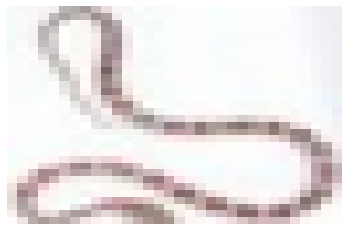

 * Cifar100_test_set Given Label: snake
 * We Guess (argmax prediction): worm
 * Label Error Found: https://labelerrors.com/static/cifar100/5369.png

Dataset: Caltech256
Finding label errors using cleanlab for 29,780 examples and 256 classes...
Estimated number of errors in caltech256: 2344


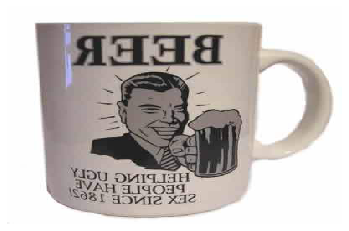

 * Caltech256 Given Label: beer-mug
 * We Guess (argmax prediction): coffee-mug
 * Label Error Found: https://labelerrors.com/static/caltech256/010.beer-mug/010_0028.jpg

Dataset: Imagenet_val_set
Finding label errors using cleanlab for 50,000 examples and 1000 classes...
Estimated number of errors in imagenet_val_set: 6278


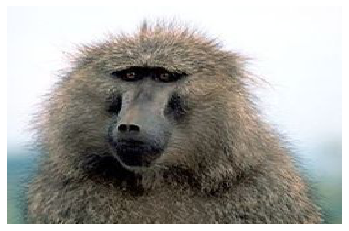

 * Imagenet_val_set Given Label: siamang
 * We Guess (argmax prediction): baboon
 * Label Error Found: https://labelerrors.com/static/imagenet/val/n02483708/ILSVRC2012_val_00047520.JPEG

Dataset: 20news_test_set
Finding label errors using cleanlab for 7,532 examples and 20 classes...
Estimated number of errors in 20news_test_set: 95

20news_test_set Text Example (ID: 6053):
From: rwf2@ns1.cc.lehigh.edu (ROBERT WILLIAM FUSI)
Subject: FOR SALE: '91 Toyota Camry $9500
Organization: Lehigh University
Lines: 20

1991 Toyota Camry for sale:
    Deluxe package
    5 speed
    grey
    power windows
    power door locks
    AM/FM cassette
    power steering
    power brakes
    70K highway miles
    Excellent condition

    $9500                             Rob Fusi
                                      rwf2@lehigh.edu
    (609) 397-2147 after 7pm          E-mail me for more info...
    (914) 335-6984 day (until 5)
    Ask for Bob Fusi

                                    
-- 


 * 20news_test

In [6]:
for (dataset, modality) in datasets:
    title = 'Dataset: ' + dataset.capitalize()
    print('='*len(title), title, '='*len(title), sep='\n')
    
    # Get the cross-validated predicted probabilities on the test set.
    if dataset == 'amazon' or dataset == 'imagenet_val_set':
        n_parts = 3 if dataset == 'amazon' else 4
        pyx_fn = '../cross_validated_predicted_probabilities/' \
             '{}_pyx.part{}_of_{}.npy'
        parts = [np.load(pyx_fn.format(dataset, i + 1, n_parts)) for i in range(n_parts)]
        pyx = np.vstack(parts)
    else:
        pyx = np.load('../cross_validated_predicted_probabilities/' \
            '{}_pyx.npy'.format(dataset), allow_pickle=True)
    # Get the cross-validated predictions (argmax of pyx) on the test set.
    pred = np.load('../cross_validated_predicted_labels/'
        '{}_pyx_argmax_predicted_labels.npy'.format(dataset), allow_pickle=True)
    # Get the test set labels
    labels = np.load('../original_test_labels/'
        '{}_original_labels.npy'.format(dataset), allow_pickle=True)
    
    if reproduce_labelerrors_website:
        label_error_indices = get_label_error_indices_to_match_labelerrors_com()
    else:
        # Find label error indices using cleanlab in one line of code. 
        # This will use the most recent version of cleanlab with best results.
        print('Finding label errors using cleanlab for {:,} '
              'examples and {} classes...'.format(*pyx.shape))
        label_error_indices = cleanlab.pruning.get_noise_indices(
            s=labels,
            psx=pyx,
            # Try prune_method='both' (C+NR in the confident learning paper)
            # 'both' finds fewer errors, but can sometimes increase precision
            prune_method='prune_by_noise_rate',
            multi_label=True if dataset == 'audioset_eval_set' else False,
            sorted_index_method='self_confidence',
        )
    num_errors = len(label_error_indices)
    print('Estimated number of errors in {}:'.format(dataset), num_errors)
    
    # Print an example
    # Grab the first label error found with cleanlab
    err_id = label_error_indices[0]
    
    # Custom code to visualize each label error from each dataset
    dname = dataset.split('_')[0]  # Get dataset name
    url_base = "https://labelerrors.com/static/{}/{}".format(dname, err_id)
    if modality == 'image':
        if dataset == 'imagenet_val_set':
            image_path = IMAGENET_INDEX_TO_FILEPATH[err_id]
            url = url_base.replace(str(err_id), image_path)
        elif dataset == 'caltech256':
            image_path = CALTECH256_INDEX_TO_FILENAME[err_id]
            url = url_base.replace(str(err_id), image_path)
        else:
            url = url_base + ".png"
        image = io.imread(url)  # read image data from a url
        plt.imshow(image, interpolation='nearest', aspect='auto', cmap='gray')
        plt.show()
    elif modality == 'text':
        if dataset == 'amazon':
            # There are 400,000+ amazon reviews errors -- we only check a small
            # fraction on labelerrors.com, so choose one that's on the website.
            err_id = 8864504
            assert err_id in label_error_indices  # Did we find this error?
            url = "https://labelerrors.com/static/{}/{}.txt".format(dname, err_id)
        elif dataset == 'imdb_test_set':
            imdb_fn = IMDB_INDEX_TO_FILENAME[err_id]  
            url = "https://labelerrors.com/static/{}/test/{}".format(dname, imdb_fn)
        else:
            url = url_base + ".txt"
        text = urlopen(url).read().decode("utf-8")  # read raw text from a url
        print('\n{} Text Example (ID: {}):\n{}\n'.format(
            dataset.capitalize(), err_id, text))
    elif modality == 'audio':  # dataset == 'audioset_eval_set'
        # Because AudioSet is multi-label, we only look at examples where the 
        # predictions have no overlap with the labels to avoid overcounting.
        label_error_indices = [z for z in label_error_indices \
                if set(pred[z]).intersection(labels[z]) == set()]
        err_id = label_error_indices[1]
        youtube_id = AUDIOSET_INDEX_TO_YOUTUBE[err_id]
        url = youtube_id.replace('http', 'https')
    # Map label indices to class names
    if dataset == 'audioset_eval_set':  # multi-label    
        given_label = [ALL_CLASSES[dataset][z] for z in labels[err_id]]
        pred_label = [ALL_CLASSES[dataset][z] for z in pred[err_id]]
    else:  # single-label
        given_label = ALL_CLASSES[dataset][labels[err_id]]
        pred_label = ALL_CLASSES[dataset][pred[err_id]]
    print(' * {} Given Label:'.format(dataset.capitalize()), given_label)
    print(' * We Guess (argmax prediction):', pred_label)
    print(' * Label Error Found: {}\n'.format(url))